# **Week 5: Route and Airport-Level Analysis**

In [0]:
import pandas as pd
output_path = "/Volumes/workspace/airlines/flight/cleaned_dataset.csv"
data = pd.read_csv(output_path)
display(data.head(10))

DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Org_Airport,Dest,Dest_Airport,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DurationDiff,DepDelayed_Flag,ArrDelayed_Flag,TotalDelay,Month,DayOfWeekNum,DayName,Hour,Route,IsWeekend,TIME_OF_DAY
4,2019-03-01,18:29:00,1959,1925,11,9,3920,N464WN,90,90,77,34,34,124,105,42,15,515,3,10,0,0,0,2,0,0,0,32,0,1,1,34,3,4,Friday,null,124 → 42,0,Unknown
4,2019-03-01,19:37:00,2037,1940,11,9,509,N763SW,240,250,230,57,67,124,105,138,143,1591,3,7,0,0,0,10,0,0,0,47,-10,1,1,57,3,4,Friday,null,124 → 138,0,Unknown
4,2019-03-01,16:44:00,1845,1725,11,9,1333,N334SW,121,135,107,80,94,124,105,158,172,828,6,8,0,0,0,8,0,0,0,72,-14,1,1,80,3,4,Friday,null,124 → 158,0,Unknown
4,2019-03-01,14:52:00,1640,1625,11,9,675,N286WN,228,240,213,15,27,124,105,199,178,1489,7,8,0,0,0,3,0,0,0,12,-12,1,1,15,3,4,Friday,null,124 → 199,0,Unknown
4,2019-03-01,13:23:00,1526,1510,11,9,4,N674AA,123,135,110,16,28,124,105,256,226,838,4,9,0,0,0,0,0,0,0,16,-12,1,1,16,3,4,Friday,null,124 → 256,0,Unknown
4,2019-03-01,14:16:00,1512,1435,11,9,54,N643SW,56,70,49,37,51,126,132,42,15,220,2,5,0,0,0,12,0,0,0,25,-14,1,1,37,3,4,Friday,null,126 → 42,0,Unknown
4,2019-03-01,16:57:00,1754,1735,11,9,623,N724SW,57,70,47,19,32,126,132,42,15,220,5,5,0,0,0,7,0,0,0,12,-13,1,1,19,3,4,Friday,null,126 → 42,0,Unknown
4,2019-03-01,14:22:00,1657,1610,11,9,188,N215WN,155,195,143,47,87,126,132,93,77,1093,6,6,0,0,0,40,0,0,0,7,-40,1,1,47,3,4,Friday,null,126 → 93,0,Unknown
4,2019-03-01,21:07:00,2334,2230,11,9,362,N798SW,147,165,134,64,82,126,132,158,172,972,6,7,0,0,0,5,0,0,0,59,-18,1,1,64,3,4,Friday,null,126 → 158,0,Unknown
4,2019-03-01,18:12:00,1927,1815,11,9,422,N779SW,135,145,118,72,82,126,132,160,43,765,6,11,0,0,0,3,0,0,0,69,-10,1,1,72,3,4,Friday,null,126 → 160,0,Unknown


Org_Airport,Dest_Airport,Flight_Count,Route
251,53,949,251 → 53
142,134,921,142 → 134
52,251,845,52 → 251
205,134,816,205 → 134
178,143,815,178 → 143
133,205,705,133 → 205
133,170,701,133 → 170
58,143,695,58 → 143
133,168,681,133 → 168
178,204,670,178 → 204


/home/spark-51e92e16-5b18-4bb4-a436-a7/.ipykernel/2457/command-8376522952111478-1508721975:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


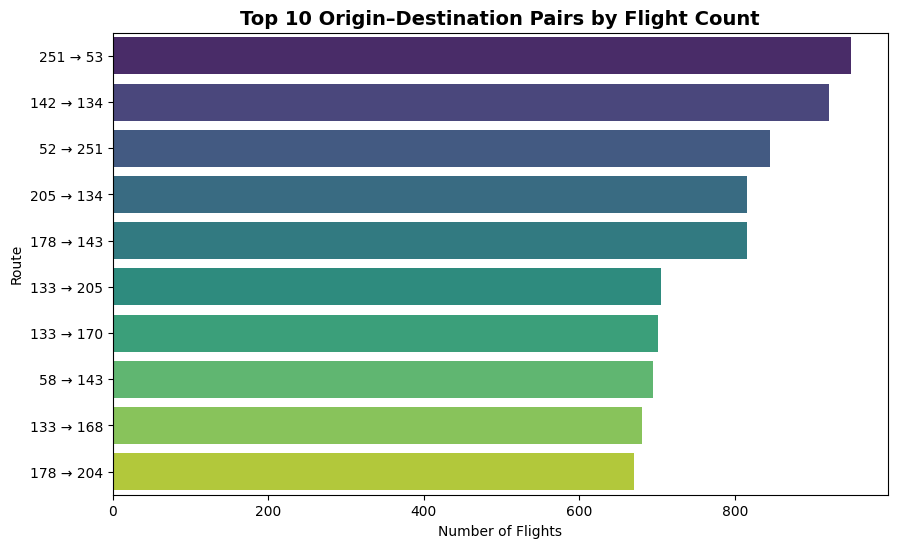

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

if all(col in data.columns for col in ['Org_Airport', 'Dest_Airport']):
    top_routes = (
        data.groupby(['Org_Airport', 'Dest_Airport'])
        .size()
        .reset_index(name='Flight_Count')
        .sort_values(by='Flight_Count', ascending=False)
        .head(10)
    )
    top_routes['Route'] = (
        top_routes['Org_Airport'].astype(str) + ' → ' + top_routes['Dest_Airport'].astype(str)
    )
    display(top_routes)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_routes,
        x='Flight_Count',
        y='Route',
        palette='viridis'
    )
    plt.title("Top 10 Origin–Destination Pairs by Flight Count", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Flights")


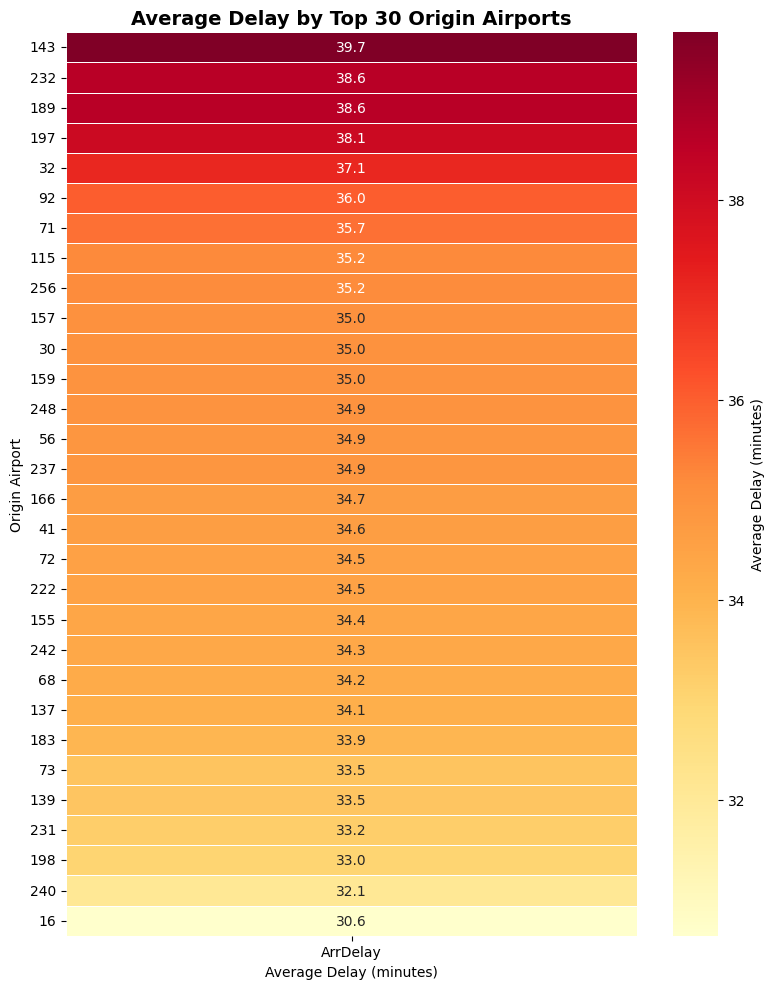

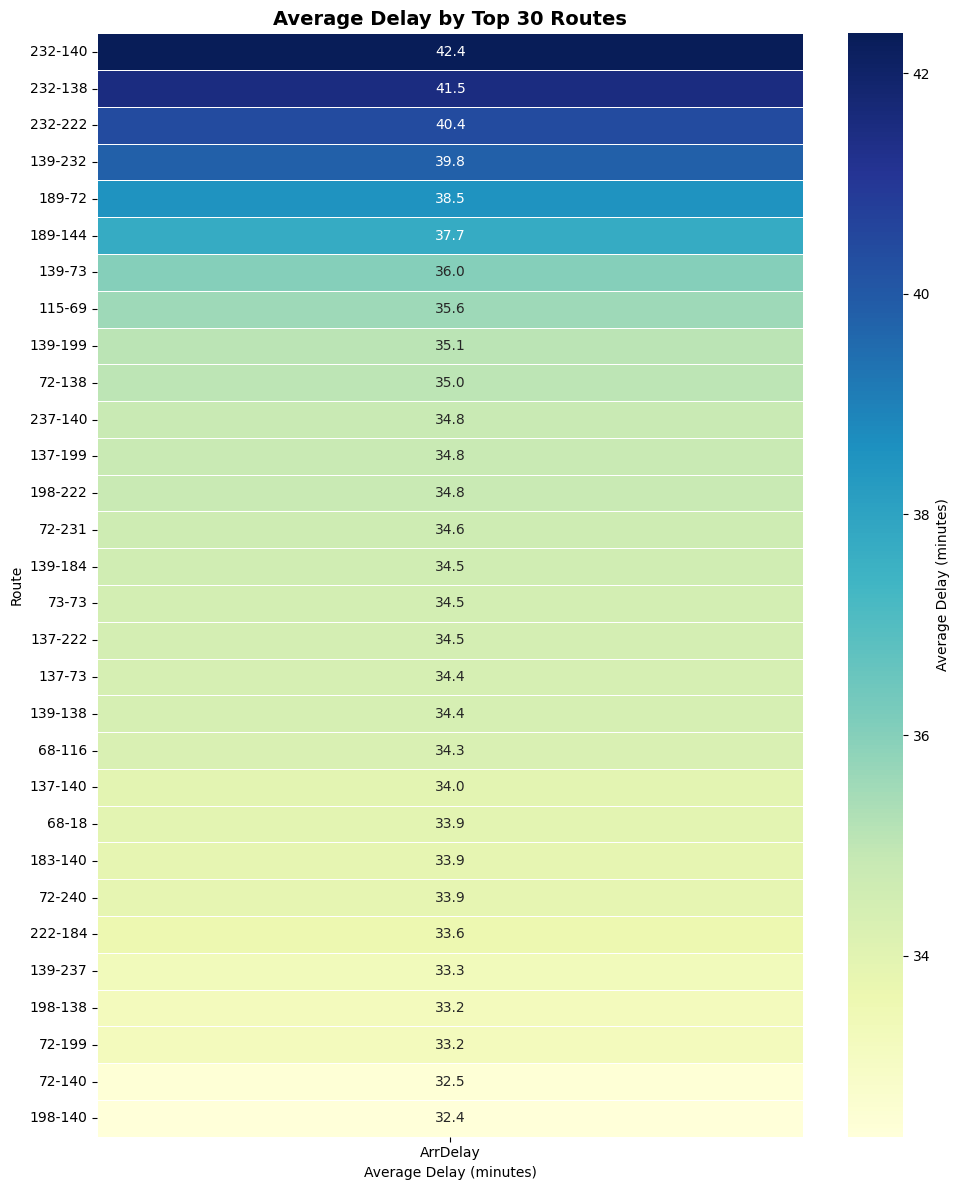


**Observation:**
- The heatmaps above show the average delay (in minutes) for the top 30 origin airports and top 30 routes.
- The airport with the highest average delay is **143.0** with **39.7** minutes.
- The airport with the lowest average delay among the top 30 is **16.0** with **30.6** minutes.
- The route with the highest average delay is **232-140** with **42.4** minutes.
- The route with the lowest average delay among the top 30 is **198-140** with **32.4** minutes.
- These insights can help identify bottlenecks and efficient corridors in the flight network.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

delay_candidates = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DELAY', 'DEP_DELAY', 'ARR_DELAY']
origin_candidates = ['ORIGIN', 'ORIGIN_AIRPORT', 'ORIGIN_AIRPORT_CODE', 'AIRPORT']
dest_candidates = ['DEST', 'DESTINATION', 'DEST_AIRPORT', 'DEST_AIRPORT_CODE']

def find_col(candidates, df):
    for c in candidates:
        if c in df.columns:
            return c
    for c in candidates:
        for col in df.columns:
            if c.lower() in col.lower():
                return col
    return None

delay_col = find_col(delay_candidates, data)
origin_col = find_col(origin_candidates, data)
dest_col = find_col(dest_candidates, data)

if not delay_col or not origin_col or not dest_col:
    raise ValueError("Could not find suitable delay, origin, or destination columns in your dataset!")

if 'ROUTE' not in data.columns:
    data['ROUTE'] = data[origin_col].astype(str) + '-' + data[dest_col].astype(str)

data[delay_col] = pd.to_numeric(data[delay_col], errors='coerce')
top_30_airports = data[origin_col].value_counts().nlargest(30).index
top_30_routes = data['ROUTE'].value_counts().nlargest(30).index
airport_data = data[data[origin_col].isin(top_30_airports)]
route_data = data[data['ROUTE'].isin(top_30_routes)]
airport_delay = (
    airport_data.groupby(origin_col)[delay_col]
    .mean()
    .reset_index()
    .sort_values(by=delay_col, ascending=False)
)
route_delay = (
    route_data.groupby('ROUTE')[delay_col]
    .mean()
    .reset_index()
    .sort_values(by=delay_col, ascending=False)
)
airport_pivot = airport_delay.set_index(origin_col)
route_pivot = route_delay.set_index('ROUTE')
plt.figure(figsize=(8, 10))
sns.heatmap(
    airport_pivot,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Average Delay (minutes)'}
)
plt.title("Average Delay by Top 30 Origin Airports", fontsize=14, fontweight='bold')
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Origin Airport")
plt.tight_layout()
display(plt.gcf())
plt.close()

plt.figure(figsize=(10, 12))
sns.heatmap(
    route_pivot,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Average Delay (minutes)'}
)
plt.title("Average Delay by Top 30 Routes", fontsize=14, fontweight='bold')
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Route")
plt.tight_layout()
display(plt.gcf())
plt.close()

# Add insights/observation
max_airport = airport_delay.iloc[0][origin_col]
max_airport_delay = airport_delay.iloc[0][delay_col]
min_airport = airport_delay.iloc[-1][origin_col]
min_airport_delay = airport_delay.iloc[-1][delay_col]

max_route = route_delay.iloc[0]['ROUTE']
max_route_delay = route_delay.iloc[0][delay_col]
min_route = route_delay.iloc[-1]['ROUTE']
min_route_delay = route_delay.iloc[-1][delay_col]

observation = f"""
**Observation:**
- The heatmaps above show the average delay (in minutes) for the top 30 origin airports and top 30 routes.
- The airport with the highest average delay is **{max_airport}** with **{max_airport_delay:.1f}** minutes.
- The airport with the lowest average delay among the top 30 is **{min_airport}** with **{min_airport_delay:.1f}** minutes.
- The route with the highest average delay is **{max_route}** with **{max_route_delay:.1f}** minutes.
- The route with the lowest average delay among the top 30 is **{min_route}** with **{min_route_delay:.1f}** minutes.
- These insights can help identify bottlenecks and efficient corridors in the flight network.
"""
display(Markdown(observation))

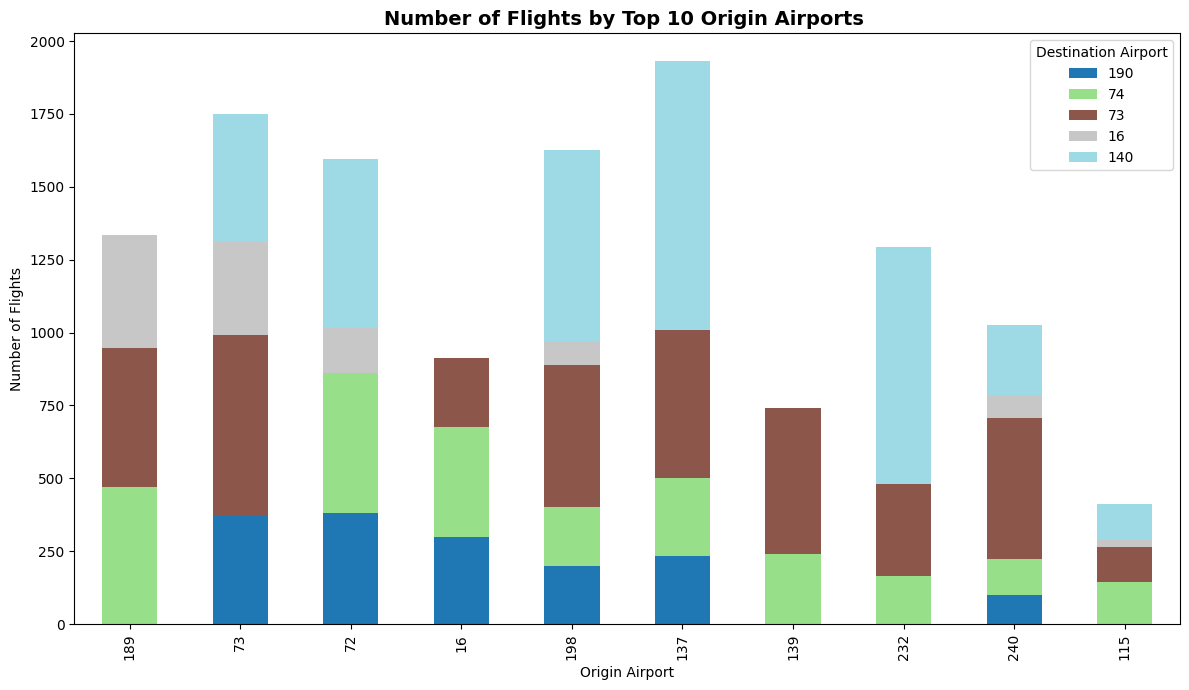


**Observation:**
- The stacked bar chart shows the distribution of flights from the top 10 origin airports to the top 5 destination airports.
- The origin airport with the highest total number of flights (to these top destinations) is **137** with **1930** flights.
- The most popular destination among these is **140** with **3776** flights from the top origins.
- This visualization highlights key airport hubs and their most frequent connections.


In [0]:
top_10_origins = data[origin_col].value_counts().nlargest(10).index
top_5_dests = data[dest_col].value_counts().nlargest(5).index

stacked_data = (
    data[data[origin_col].isin(top_10_origins) & data[dest_col].isin(top_5_dests)]
    .groupby([origin_col, dest_col])
    .size()
    .unstack(fill_value=0)
    .loc[top_10_origins, top_5_dests]
)

stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'
)
plt.title("Number of Flights by Top 10 Origin Airports ", fontsize=14, fontweight='bold')
plt.xlabel("Origin Airport")
plt.ylabel("Number of Flights")
plt.legend(title="Destination Airport")
plt.tight_layout()
display(plt.gcf())
plt.close()
top_origin = stacked_data.sum(axis=1).idxmax()
top_origin_count = stacked_data.sum(axis=1).max()
top_dest = stacked_data.sum(axis=0).idxmax()
top_dest_count = stacked_data.sum(axis=0).max()

from IPython.display import Markdown
observation = f"""
**Observation:**
- The stacked bar chart shows the distribution of flights from the top 10 origin airports to the top 5 destination airports.
- The origin airport with the highest total number of flights (to these top destinations) is **{top_origin}** with **{top_origin_count}** flights.
- The most popular destination among these is **{top_dest}** with **{top_dest_count}** flights from the top origins.
- This visualization highlights key airport hubs and their most frequent connections.
"""
display(Markdown(observation))

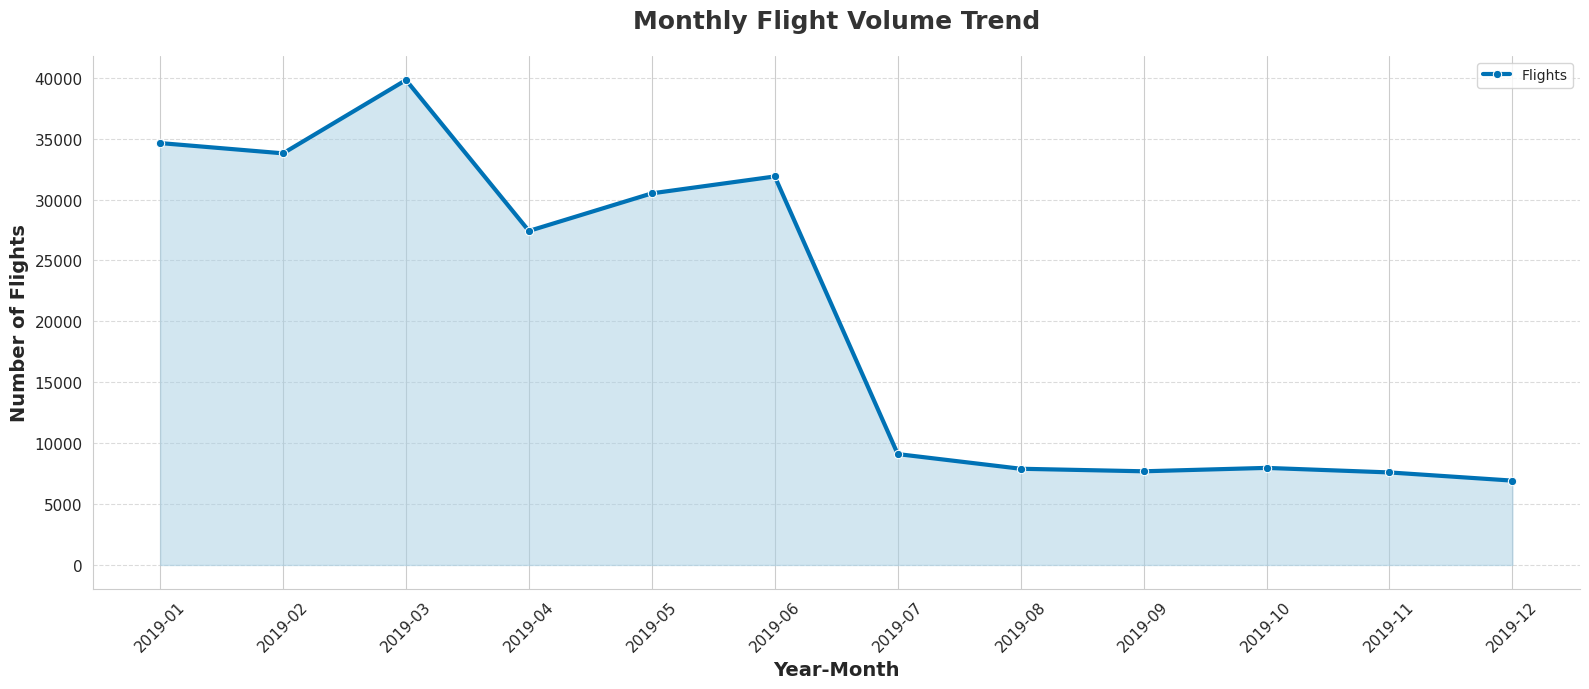


**Observation:**
- The area chart above shows the trend of total flights per month.
- The month with the highest number of flights is **2019-03** with **39815** flights.
- This visualization helps identify seasonality and trends in flight activity.


In [0]:
if 'DATE' in data.columns:
    date_col = 'DATE'
else:
    date_col = next((col for col in data.columns if 'date' in col.lower()), None)

if not date_col:
    raise ValueError("No date column found for time series analysis.")

data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
data['YEAR_MONTH'] = data[date_col].dt.to_period('M').astype(str)
monthly_flights = data.groupby('YEAR_MONTH').size().reset_index(name='FLIGHT_COUNT')

plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")
sns.lineplot(
    data=monthly_flights,
    x='YEAR_MONTH',
    y='FLIGHT_COUNT',
    marker='o',
    linewidth=3,
    color='#0072B5',
    label='Flights'
)
plt.fill_between(
    monthly_flights['YEAR_MONTH'],
    monthly_flights['FLIGHT_COUNT'],
    color='#A6CEE3',
    alpha=0.5
)
plt.title("Monthly Flight Volume Trend", fontsize=18, fontweight='bold', color='#333333', pad=20)
plt.xlabel("Year-Month", fontsize=14, fontweight='bold')
plt.ylabel("Number of Flights", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
display(plt.gcf())
plt.close()
peak_month = monthly_flights.loc[monthly_flights['FLIGHT_COUNT'].idxmax(), 'YEAR_MONTH']
peak_count = monthly_flights['FLIGHT_COUNT'].max()
observation = f"""
**Observation:**
- The area chart above shows the trend of total flights per month.
- The month with the highest number of flights is **{peak_month}** with **{peak_count}** flights.
- This visualization helps identify seasonality and trends in flight activity.
"""
display(Markdown(observation))

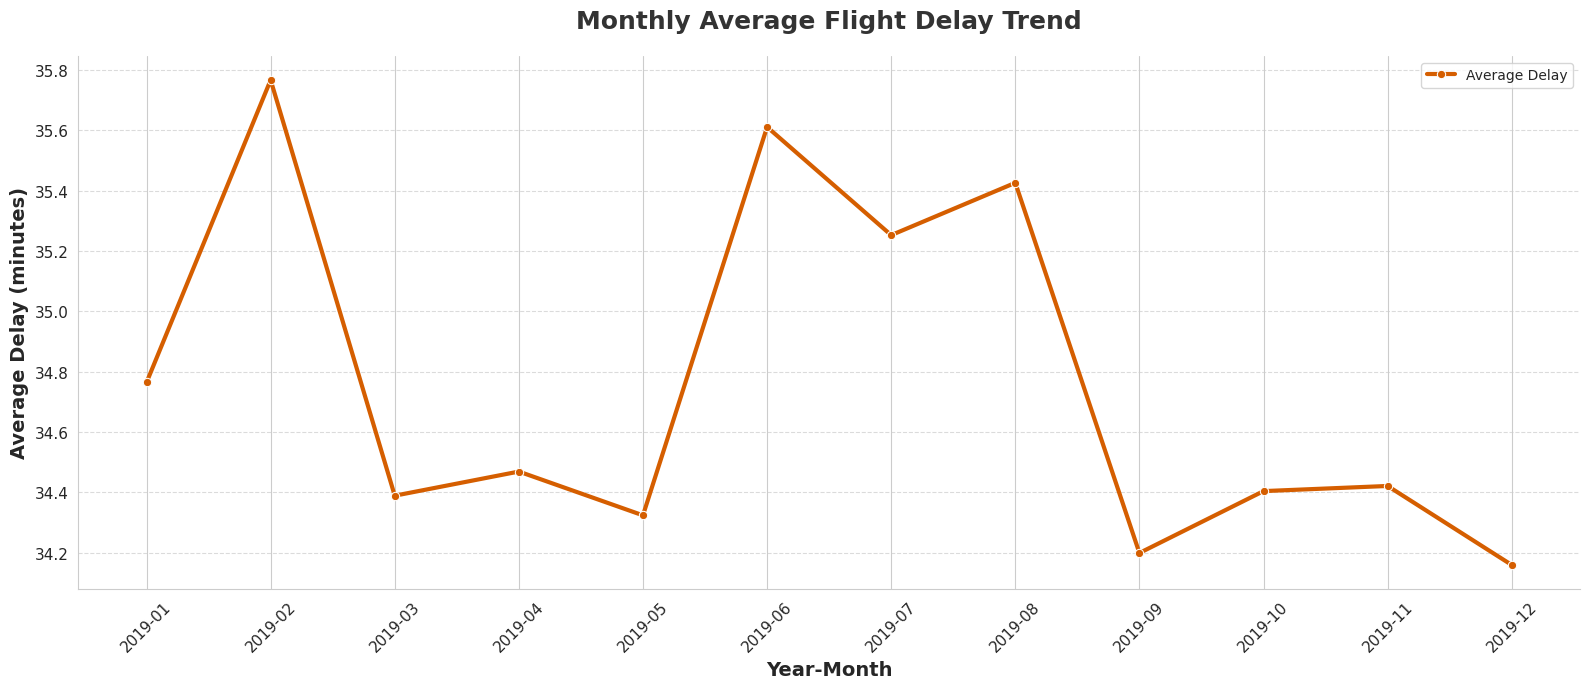


**Observation:**
- The line chart above shows the trend of average flight delay per month.
- The month with the highest average delay is **2019-02** with **35.8** minutes.
- This analysis helps identify periods with higher operational delays.


In [0]:
if not delay_col:
    raise ValueError("No delay column found for analysis.")

monthly_delay = (
    data.groupby('YEAR_MONTH')[delay_col]
    .mean()
    .reset_index(name='AVG_DELAY')
)

plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")
sns.lineplot(
    data=monthly_delay,
    x='YEAR_MONTH',
    y='AVG_DELAY',
    marker='o',
    linewidth=3,
    color='#D55E00',
    label='Average Delay'
)
plt.title("Monthly Average Flight Delay Trend", fontsize=18, fontweight='bold', color='#333333', pad=20)
plt.xlabel("Year-Month", fontsize=14, fontweight='bold')
plt.ylabel("Average Delay (minutes)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
display(plt.gcf())
plt.close()
peak_delay_month = monthly_delay.loc[monthly_delay['AVG_DELAY'].idxmax(), 'YEAR_MONTH']
peak_avg_delay = monthly_delay['AVG_DELAY'].max()
observation = f"""
**Observation:**
- The line chart above shows the trend of average flight delay per month.
- The month with the highest average delay is **{peak_delay_month}** with **{peak_avg_delay:.1f}** minutes.
- This analysis helps identify periods with higher operational delays.
"""
display(Markdown(observation))

/home/spark-51e92e16-5b18-4bb4-a436-a7/.ipykernel/2457/command-8376522952111483-2122917141:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_category_counts, x='DELAY_CATEGORY', y='FLIGHT_COUNT', palette='Set2')


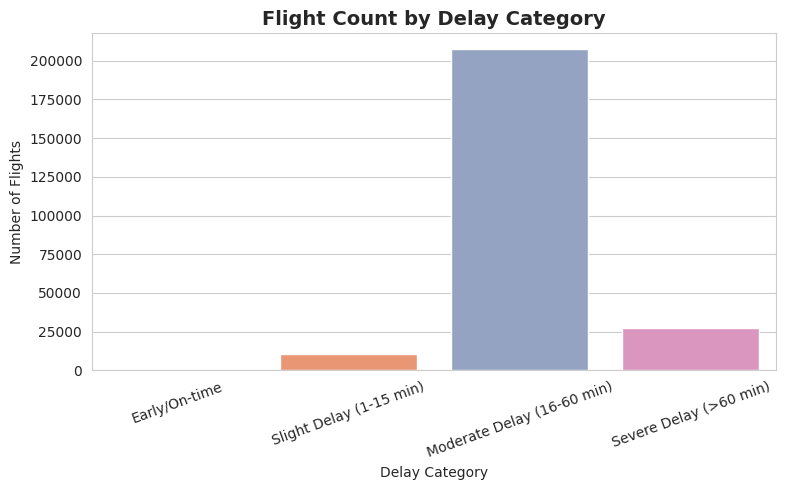


**Observation:**
- The bar chart shows the distribution of flights by delay category.
- The most common category is **Early/On-time** with **0** flights.
- This helps understand the overall punctuality and delay profile of the dataset.


In [0]:
bins = [-float('inf'), 0, 15, 60, float('inf')]
labels = ['Early/On-time', 'Slight Delay (1-15 min)', 'Moderate Delay (16-60 min)', 'Severe Delay (>60 min)']

data['DELAY_CATEGORY'] = pd.cut(data[delay_col], bins=bins, labels=labels, right=True)

delay_category_counts = data['DELAY_CATEGORY'].value_counts().reindex(labels).reset_index()
delay_category_counts.columns = ['DELAY_CATEGORY', 'FLIGHT_COUNT']

plt.figure(figsize=(8, 5))
sns.barplot(data=delay_category_counts, x='DELAY_CATEGORY', y='FLIGHT_COUNT', palette='Set2')
plt.title("Flight Count by Delay Category", fontsize=14, fontweight='bold')
plt.xlabel("Delay Category")
plt.ylabel("Number of Flights")
plt.xticks(rotation=20)
plt.tight_layout()
display(plt.gcf())
plt.close()
top_cat = delay_category_counts.iloc[0]['DELAY_CATEGORY']
top_cat_count = delay_category_counts.iloc[0]['FLIGHT_COUNT']
from IPython.display import Markdown
observation = f"""
**Observation:**
- The bar chart shows the distribution of flights by delay category.
- The most common category is **{top_cat}** with **{top_cat_count}** flights.
- This helps understand the overall punctuality and delay profile of the dataset.
"""
display(Markdown(observation))

In [0]:
import numpy as np
unique_airports = data['Org_Airport'].unique()
coords = {a: (np.random.uniform(25, 49), np.random.uniform(-125, -67)) for a in unique_airports}

data["Latitude"] = data["Org_Airport"].map(lambda x: coords[x][0])
data["Longitude"] = data["Org_Airport"].map(lambda x: coords[x][1])
display(data[['Org_Airport', 'Latitude', 'Longitude']])

,Org_Airport,Latitude,Longitude
0,105,40.675401,-86.670705
1,105,40.675401,-86.670705
2,105,40.675401,-86.670705
3,105,40.675401,-86.670705
4,105,40.675401,-86.670705
...,...,...,...
245261,53,45.733568,-110.802862
245262,53,45.733568,-110.802862
245263,53,45.733568,-110.802862
245264,53,45.733568,-110.802862


In [0]:
import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen, MeasureControl, MousePosition
import branca.colormap as cm

# Assign random world coordinates for demo (replace with real lat/lon for real data)
np.random.seed(42)
world_coords = {a: (np.random.uniform(-60, 60), np.random.uniform(-180, 180)) for a in top_airports['Org_Airport']}
top_airports['WORLD_LAT'] = top_airports['Org_Airport'].map(lambda x: world_coords[x][0])
top_airports['WORLD_LON'] = top_airports['Org_Airport'].map(lambda x: world_coords[x][1])

min_delay, max_delay = top_airports['AVG_DELAY'].min(), top_airports['AVG_DELAY'].max()
min_count, max_count = top_airports['FLIGHT_COUNT'].min(), top_airports['FLIGHT_COUNT'].max()
colormap = cm.LinearColormap(['#2ECC40', '#FFEB3B', '#FF4136'], vmin=min_delay, vmax=max_delay)
colormap.caption = 'Average Delay (minutes)'

def scale_radius(count):
    return 12 + 20 * (count - min_count) / (max_count - min_count) if max_count > min_count else 20

m_world = folium.Map(location=[10, 0], zoom_start=2, tiles='cartodbpositron')
MiniMap(toggle_display=True).add_to(m_world)
Fullscreen().add_to(m_world)
MeasureControl(primary_length_unit='kilometers').add_to(m_world)
MousePosition(
    position='bottomright',
    separator=' | ',
    prefix='Lat/Lon:',
    lat_formatter="function(num) {return L.Util.formatNum(num, 4);}",
    lng_formatter="function(num) {return L.Util.formatNum(num, 4);}"
).add_to(m_world)

marker_cluster = MarkerCluster().add_to(m_world)

for idx, row in top_airports.iterrows():
    popup_html = f"""
        <div style='font-size:15px; line-height:1.5'>
        <b>Airport:</b> <span style='color:#0072B5'>{row['Org_Airport']}</span><br>
        <b>Flights:</b> <span style='color:#009E73'>{int(row['FLIGHT_COUNT']):,}</span><br>
        <b>Avg Delay:</b> <span style='color:#D55E00'>{row['AVG_DELAY']:.1f} min</span><br>
        <b>Rank:</b> <span style='color:#6C3483'>{idx+1}</span>
        </div>
    """
    folium.CircleMarker(
        location=[row['WORLD_LAT'], row['WORLD_LON']],
        radius=scale_radius(row['FLIGHT_COUNT']),
        color=colormap(row['AVG_DELAY']),
        fill=True,
        fill_color=colormap(row['AVG_DELAY']),
        fill_opacity=0.85,
        weight=2,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=(
            f"#{idx+1} {row['Org_Airport']}: "
            f"{int(row['FLIGHT_COUNT']):,} flights, "
            f"{row['AVG_DELAY']:.1f} min avg delay"
        )
    ).add_to(marker_cluster)

colormap.add_to(m_world)

# Add average delay annotation to the map
avg_delay_all = top_airports['AVG_DELAY'].mean()
avg_delay_html = f"""
<div style="
    position: fixed; 
    top: 60px; right: 30px; width: 260px; z-index:9999; 
    background: rgba(255,255,255,0.95); 
    border-radius: 10px; 
    box-shadow: 2px 2px 8px #888888;
    padding: 14px 16px 10px 16px;
    font-size: 15px;
    line-height: 1.5;
">
<b>Average Delay (Top 20):</b><br>
<span style="font-size:20px; color:#D55E00; font-weight:bold;">{avg_delay_all:.1f} min</span>
</div>
"""
m_world.get_root().html.add_child(folium.Element(avg_delay_html))

title_html = """
     <h2 align="center" style="font-size:24px; margin-bottom:0; color:#222;">
        <b>Top 20 Busiest Airports</b>
     </h2>
     <h4 align="center" style="font-size:15px; margin-top:0; color:#555;">
        <b>Circle size</b> = Flight count &nbsp; | &nbsp; <b>Color</b> = Avg delay (green: low, red: high)
     </h4>
     """
m_world.get_root().html.add_child(folium.Element(title_html))

display(m_world)
from IPython.display import display, Markdown
how_to_read = """
<div style="
    margin-top: 24px;
    background: #f8f8f8;
    border-radius: 10px;
    box-shadow: 1px 1px 6px #e0e0e0;
    padding: 18px 18px 10px 18px;
    font-size: 15px;
    line-height: 1.6;
    width: 95%;
">
<b>How to read this map:</b><br>
<span style="color:#2ECC40; font-weight:bold;">Green</span> = Short delays<br>
<span style="color:#FFEB3B; font-weight:bold;">Yellow</span> = Moderate delays<br>
<span style="color:#FF4136; font-weight:bold;">Red</span> = Long delays<br>
<b>Circle size</b> = Number of flights<br>
<b>Hover</b> for quick info, <b>click</b> for details.<br>
<b>Use</b> map controls (minimap, fullscreen, measure, mouse position) for navigation.
</div>
"""
display(Markdown(how_to_read))


<div style="
    margin-top: 24px;
    background: #f8f8f8;
    border-radius: 10px;
    box-shadow: 1px 1px 6px #e0e0e0;
    padding: 18px 18px 10px 18px;
    font-size: 15px;
    line-height: 1.6;
    width: 95%;
">
<b>How to read this map:</b><br>
<span style="color:#2ECC40; font-weight:bold;">Green</span> = Short delays<br>
<span style="color:#FFEB3B; font-weight:bold;">Yellow</span> = Moderate delays<br>
<span style="color:#FF4136; font-weight:bold;">Red</span> = Long delays<br>
<b>Circle size</b> = Number of flights<br>
<b>Hover</b> for quick info, <b>click</b> for details.<br>
<b>Use</b> map controls (minimap, fullscreen, measure, mouse position) for navigation.
</div>


In [0]:
%pip install folium branca

import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen, BeautifyIcon, MeasureControl, MousePosition
import branca.colormap as cm
airport_stats = (
    data.groupby('Org_Airport')
    .agg(
        FLIGHT_COUNT=('Org_Airport', 'count'),
        AVG_DELAY=(delay_col, 'mean'),
        LATITUDE=('Latitude', 'first'),
        LONGITUDE=('Longitude', 'first')
    )
    .reset_index()
    .dropna(subset=['LATITUDE', 'LONGITUDE'])
)

top_airports = airport_stats.sort_values('FLIGHT_COUNT', ascending=False).head(20)
min_delay, max_delay = top_airports['AVG_DELAY'].min(), top_airports['AVG_DELAY'].max()
min_count, max_count = top_airports['FLIGHT_COUNT'].min(), top_airports['FLIGHT_COUNT'].max()
colormap = cm.LinearColormap(['#2ECC40', '#FFEB3B', '#FF4136'], vmin=min_delay, vmax=max_delay)
colormap.caption = 'Average Delay (minutes)'

def scale_radius(count):
    return 12 + 20 * (count - min_count) / (max_count - min_count) if max_count > min_count else 20
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4, tiles='cartodbpositron')
MiniMap(toggle_display=True).add_to(m)
Fullscreen().add_to(m)
MeasureControl(primary_length_unit='kilometers').add_to(m)
MousePosition(
    position='bottomright',
    separator=' | ',
    prefix='Lat/Lon:',
    lat_formatter="function(num) {return L.Util.formatNum(num, 4);}",
    lng_formatter="function(num) {return L.Util.formatNum(num, 4);}"
).add_to(m)
marker_cluster = MarkerCluster().add_to(m)
for idx, row in top_airports.iterrows():
    popup_html = f"""
        <div style='font-size:15px; line-height:1.5'>
        <b>Airport:</b> <span style='color:#0072B5'>{row['Org_Airport']}</span><br>
        <b>Flights:</b> <span style='color:#009E73'>{int(row['FLIGHT_COUNT']):,}</span><br>
        <b>Avg Delay:</b> <span style='color:#D55E00'>{row['AVG_DELAY']:.1f} min</span><br>
        <b>Rank:</b> <span style='color:#6C3483'>{idx+1}</span>
        </div>
    """
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=scale_radius(row['FLIGHT_COUNT']),
        color=colormap(row['AVG_DELAY']),
        fill=True,
        fill_color=colormap(row['AVG_DELAY']),
        fill_opacity=0.85,
        weight=2,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=(
            f"#{idx+1} {row['Org_Airport']}: "
            f"{int(row['FLIGHT_COUNT']):,} flights, "
            f"{row['AVG_DELAY']:.1f} min avg delay"
        )
    ).add_to(marker_cluster)

colormap.add_to(m)

title_html = """
     <h2 align="center" style="font-size:26px; margin-bottom:0; color:#222;">
        <b>Top 20 Busiest US Airports</b>
     </h2>
     <h4 align="center" style="font-size:17px; margin-top:0; color:#555;">
        <b>Circle size</b> = Flight count &nbsp; | &nbsp; <b>Color</b> = Avg delay (green: low, red: high)
     </h4>
     """
m.get_root().html.add_child(folium.Element(title_html))

display(m)

from IPython.display import display, Markdown
how_to_read = """
<div style="
    margin-top: 24px;
    background: #f8f8f8;
    border-radius: 10px;
    box-shadow: 1px 1px 6px #e0e0e0;
    padding: 18px 18px 10px 18px;
    font-size: 15px;
    line-height: 1.6;
    width: 95%;
">
<b>How to read this map:</b><br>
<span style="color:#2ECC40; font-weight:bold;">Green</span> = Short delays<br>
<span style="color:#FFEB3B; font-weight:bold;">Yellow</span> = Moderate delays<br>
<span style="color:#FF4136; font-weight:bold;">Red</span> = Long delays<br>
<b>Circle size</b> = Number of flights<br>
<b>Hover</b> for quick info, <b>click</b> for details.<br>
<b>Use</b> map controls (minimap, fullscreen, measure, mouse position) for navigation.
</div>
"""
display(Markdown(how_to_read))

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.



<div style="
    margin-top: 24px;
    background: #f8f8f8;
    border-radius: 10px;
    box-shadow: 1px 1px 6px #e0e0e0;
    padding: 18px 18px 10px 18px;
    font-size: 15px;
    line-height: 1.6;
    width: 95%;
">
<b>How to read this map:</b><br>
<span style="color:#2ECC40; font-weight:bold;">Green</span> = Short delays<br>
<span style="color:#FFEB3B; font-weight:bold;">Yellow</span> = Moderate delays<br>
<span style="color:#FF4136; font-weight:bold;">Red</span> = Long delays<br>
<b>Circle size</b> = Number of flights<br>
<b>Hover</b> for quick info, <b>click</b> for details.<br>
<b>Use</b> map controls (minimap, fullscreen, measure, mouse position) for navigation.
</div>
